<a href="https://colab.research.google.com/github/artiboi2002/dp-poisoning-attacks/blob/main/dp_poisioning_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
# Convernt MNIST image files into tensor of 4 dimensions(# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [74]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [75]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [76]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [77]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [78]:
# Create a small batch size for images for example 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In [79]:
#Define our convolutional neuro network model
#Describe Convolutional Layer and whats its doing (2 convolutional layer) - just example
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3,1)

In [80]:
# Grab 1 MNIST record/image
for i, (X_Train, Y_Train) in enumerate(train_data):
  break

In [81]:
X_Train.shape

torch.Size([1, 28, 28])

In [82]:
x = X_Train.view(1,1,28,28)

In [83]:
#Perform our firt confoloctuion
x = F.relu(conv1(x)) #Recified Linear Unit for our activiation function

In [84]:
#1 single image, 6 the filters, 26 by 26 is the image.
x.shape

torch.Size([1, 6, 26, 26])

In [85]:
# pass throught the pooling layer
x = F.max_pool2d(x, 2,2) #kernal of 2 and stride of 2

In [86]:
x.shape

torch.Size([1, 6, 13, 13])

In [87]:
# Second convultional layer
x = F.relu(conv2(x))

In [88]:
x.shape #We didnt set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [89]:
#Pooling layer
x = F.max_pool2d(x, 2,2)

In [90]:
x.shape #11/2 is 5.5 but we need to round down because we cant invent the data

torch.Size([1, 16, 5, 5])

In [91]:
#(28-2) / 2-2) / 2 = 5.5

In [92]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2,2) #2x2 kernal and a stride of 2
    x = F.relu(self.conv2(x)) #1 image, 6 output, 3 kernal, 1 stride
    x = F.max_pool2d(x, 2, 2)

    #Review to flatten in out
    x = x.view(-1, 16*5*5)

    #Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim = 1)

In [93]:
#Create an instaste of the model
torch.manual_seed(41)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [94]:
# Loss function optimizer
critirion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #Smaller the learning rate the longer is gonna take to train

In [97]:
import time
start_time = time.time()
#Create variables to Track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


#For loop of epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

#Train
  for b,(X_Train, Y_Train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred = model(X_Train) #get prediciet values values from the training set
    loss = critirion(y_pred, Y_Train) #Compare the prediticion to the correct answers in y_train

    predicted = torch.max(y_pred.data,1)[1] #add up the number of correct predictions.
    batch_corr = (predicted == Y_Train).sum() #how many we got correct from this specific batch T = 1 F = 0
    train_corr += batch_corr #keep track as we go along and train

    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#print some results
    if b%600 == 0:
      print(f'epoch: {i} Batch {b} loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)
#Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = critirion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)

current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes')

epoch: 0 Batch 600 loss: 0.07131509482860565
epoch: 0 Batch 1200 loss: 0.003655762877315283
epoch: 0 Batch 1800 loss: 0.0023013839963823557
epoch: 0 Batch 2400 loss: 0.0029739486053586006
epoch: 0 Batch 3000 loss: 5.5486867495346814e-05
epoch: 0 Batch 3600 loss: 0.006476846989244223
epoch: 0 Batch 4200 loss: 0.0001920349313877523
epoch: 0 Batch 4800 loss: 0.007294879760593176
epoch: 0 Batch 5400 loss: 0.0002611011441331357
epoch: 0 Batch 6000 loss: 0.0003848215565085411
epoch: 1 Batch 600 loss: 0.0026227659545838833
epoch: 1 Batch 1200 loss: 0.13536551594734192
epoch: 1 Batch 1800 loss: 0.28866511583328247
epoch: 1 Batch 2400 loss: 0.034677911549806595
epoch: 1 Batch 3000 loss: 0.1278015822172165
epoch: 1 Batch 3600 loss: 0.002678908407688141
epoch: 1 Batch 4200 loss: 0.06549855321645737
epoch: 1 Batch 4800 loss: 0.00030171877006068826
epoch: 1 Batch 5400 loss: 0.004392572678625584
epoch: 1 Batch 6000 loss: 0.06843989342451096
epoch: 2 Batch 600 loss: 0.04648704081773758
epoch: 2 Batch

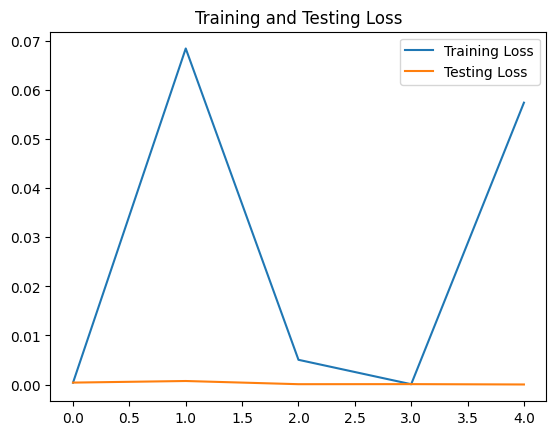

In [99]:
train_losses = [tl.item() for tl in train_losses]
test_losses = [tl.item() for tl in test_losses]
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testing Loss')
plt.title('Training and Testing Loss')
plt.legend()